## X-Ray Abnormality Detection with CNNs

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [ ]:
# TODO: remove
# !pip install scipy
# !pip install git+https://github.com/keras-team/keras-tuner

In [1]:
import gc
import os
import pathlib
import random
import re
from glob import glob

# import keras_tuner as kt
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from plotnine import *


pd.set_option("max_colwidth", None)
# from scipy import optimize  # TODO: remove

In [2]:
SEED = 123456

random.seed(SEED)

In [3]:
print(tf.__version__)

2.8.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-03-17 18:38:21.385642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 18:38:21.397120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 18:38:21.397460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Data Loading

In [5]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [6]:
DATASET_DIR = "data/MURA-v1.1/"

In [7]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['data/MURA-v1.1/train/XR_WRIST/patient08677/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_WRIST/patient08822/study1_negative/image3.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient05309/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_FINGER/patient04573/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient05276/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_FOREARM/patient09254/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient03454/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_HAND/patient07839/study1_negative/image2.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient06081/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_FINGER/patient03997/study1_negative/image1.png']

In [8]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <data/MURA-v1.1/>: 40009


In [22]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [23]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [24]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [25]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [26]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [27]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [28]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


In [29]:
batch_size = 32
img_height = 180
img_width = 180

In [33]:
# TODO: declare TensorSpec in order to provide str, int pairs
dataset = tf.data.Dataset.from_tensor_slices(
    tensors=ref_trainset[["image_path", "label"]].values.tolist()
)

2022-03-17 18:41:01.965204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 18:41:01.966624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 18:41:01.966821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 18:41:01.966940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [34]:
for image in dataset.take(5):
    print(image.numpy())

[b'data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'
 b'1']
[b'data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png'
 b'1']
[b'data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png'
 b'1']
[b'data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png'
 b'1']
[b'data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png'
 b'1']


In [35]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [36]:
def process_path(file_path: tf.Tensor) -> tuple:

    img = tf.io.read_file(file_path[0])
    img = decode_img(img)

    return img, file_path[1]

In [37]:
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
for image, label in dataset.take(1):

    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  b'1'


### Exploratory Data Analysis

Each study contains one or more views (images) and is labeled as either normal or abnormal.

The training dataset consists of `13456` studies with a total of `36807` images.

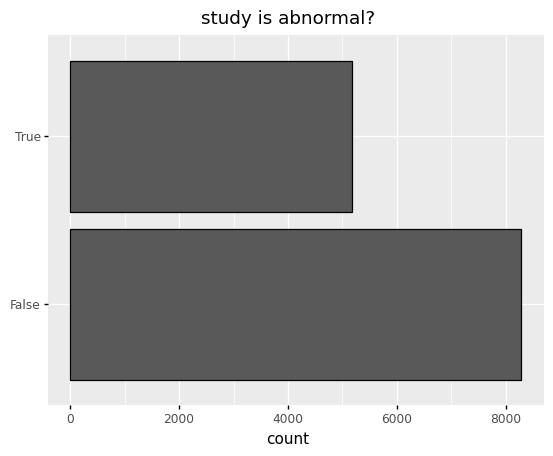

<ggplot: (8755334474216)>

In [39]:
abnormal = train_labeled_studies["label"] == "1"

(
    ggplot()
    + geom_bar(mapping=aes(x=abnormal), colour="black")
    + labs(title="study is abnormal?", x="")
    + coord_flip()
)

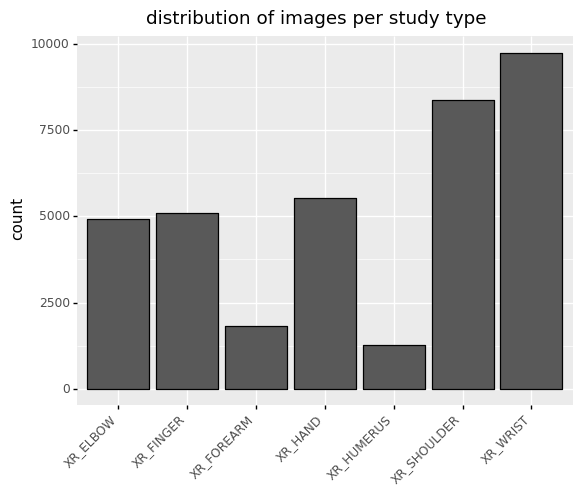

<ggplot: (8755334479866)>

In [40]:
(
    ggplot(train_image_paths)
    + geom_bar(aes(x="study_type"), colour="black")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="", y="count", title="distribution of images per study type")
)

### Hyperparameter Tuning

In [41]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

In [42]:
dataset = configure_for_performance(dataset)

In [43]:
val_size = int(len(ref_trainset.index) * 0.2)

trainset = dataset.skip(val_size)
validationset = dataset.take(val_size)

In [ ]:
image_batch, label_batch = next(iter(trainset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(label.numpy())
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(2),
    ]
)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
model.fit(trainset, validation_data=val_ds, epochs=3)

### Model Selection

### Evaluation